# Roman configurations

In [35]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.Pipelines.sl_hammocks_pipeline import SLHammocksPipeline
import speclite
from astropy.cosmology import default_cosmology
from astropy.units import Quantity
import corner
from glob import glob
from pprint import pprint

repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
import mejiro
from mejiro.instruments.roman import Roman

%matplotlib inline

In [36]:
# Import default Roman Space Telescope configuration
skypy_config = "roman-like.yml"

# Load Roman filters
roman = Roman()
roman.load_skypy_filters(sca=1)

In [30]:
# define a cosmology
cosmo = default_cosmology.get()

# define a sky area
sky_area = Quantity(value=0.5, unit="deg2")

# run skypy pipeline and make galaxy-galaxy population class
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config,
    sky_area=sky_area,
    filters=None,
)

# Generate halo galaxy population using SLHammock pipeline. Halo galaxies from this simulation
# will be used as deflector population. One can specify minimum and maximum values for
# redshift and log10 of halo mass.
halo_galaxy_pipeline = SLHammocksPipeline(
    slhammocks_config=None,
    sky_area=sky_area,
    cosmo=cosmo
)

In [41]:
# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F129", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut = {"band": "F129", "band_max": 28, "z_min": 0.01, "z_max": 5.0}

lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
)

source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

# # Initiate deflector population class.
# lens_galaxies = deflectors.CompoundLensHalosGalaxies(
#     halo_galaxy_list=halo_galaxy_pipeline._pipeline,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light={},
#     cosmo=cosmo,
#     sky_area=sky_area,
# )

# # Initiate source population class.
# source_galaxies = sources.Galaxies(
#     galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_source_cut,
#     cosmo=cosmo,
#     sky_area=sky_area,
#     catalog_type="skypy",
# )

lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

In [42]:
kwargs_lens_cut = {
    "min_image_separation": 0.1,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 21, "F062": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/slsim/ParamDistributions/kext_gext_distributions.py:126: UserWarning: No file found, provide 0 instead.
  warnings.warn("No file found, provide 0 instead.")


In [53]:
sample_gglens = lens_population[0]

pprint(sample_gglens.__dict__)

{'_extended_source_magnification': 1.7748139552471995,
 '_kwargs_lens': [{'center_x': -0.11209745541100564,
                   'center_y': 0.18137521278790592,
                   'e1': -0.14226693654413217,
                   'e2': 0.16642623948673985,
                   'theta_E': 0.6312080793389581},
                  {'dec_0': 0, 'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0},
                  {'dec_0': 0, 'kappa': 0.0, 'ra_0': 0}],
 '_lens_cosmo': <lenstronomy.Cosmo.lens_cosmo.LensCosmo object at 0x7fbb96a16290>,
 '_lens_equation_solver': 'lenstronomy_analytical',
 '_lens_mass_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 '_magnification_limit': 0.01,
 '_max_redshift_source_index': 0,
 '_source_type': 'extended',
 '_theta_E_list': [0.6312080793389581],
 'cosmo': FlatLambdaCDM(name='Planck18',
                        H0=<Quantity 67.66 km / (Mpc s)>,
                        Om0=0.30966,
                        Tcmb0=<Quantity 2.7255 K>,
                        Neff=3.046,
             

In [50]:
# print("Number of lenses:", len(lens_population))

# lens_samples = []
# labels = [
#     r"$\sigma_v$",
#     r"$\log(M_{*})$",
#     r"$\log(h_{m})$",
#     r"$\theta_E$",
#     r"$z_{\rm l}$",
#     r"$z_{\rm s}$",
#     r"$m_{\rm source}$",
#     r"$m_{\rm lens}$",
# ]

# for gg_lens in lens_population:
#     vel_disp = gg_lens.deflector_velocity_dispersion()
#     m_star = gg_lens.deflector_stellar_mass()
#     halo_mass = gg_lens.deflector.halo_properties[0]
#     theta_e = gg_lens.einstein_radius[0]
#     zl = gg_lens.deflector_redshift
#     zs = gg_lens.source_redshift_list[0]
#     source_mag = gg_lens.extended_source_magnitude(band="i", lensed=True)[0]
#     deflector_mag = gg_lens.deflector_magnitude(band="i")
#     lens_samples.append(
#         [
#             vel_disp,
#             np.log10(m_star),
#             np.log10(halo_mass),
#             theta_e,
#             zl,
#             zs,
#             source_mag,
#             deflector_mag,
#         ]
#     )

print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 298


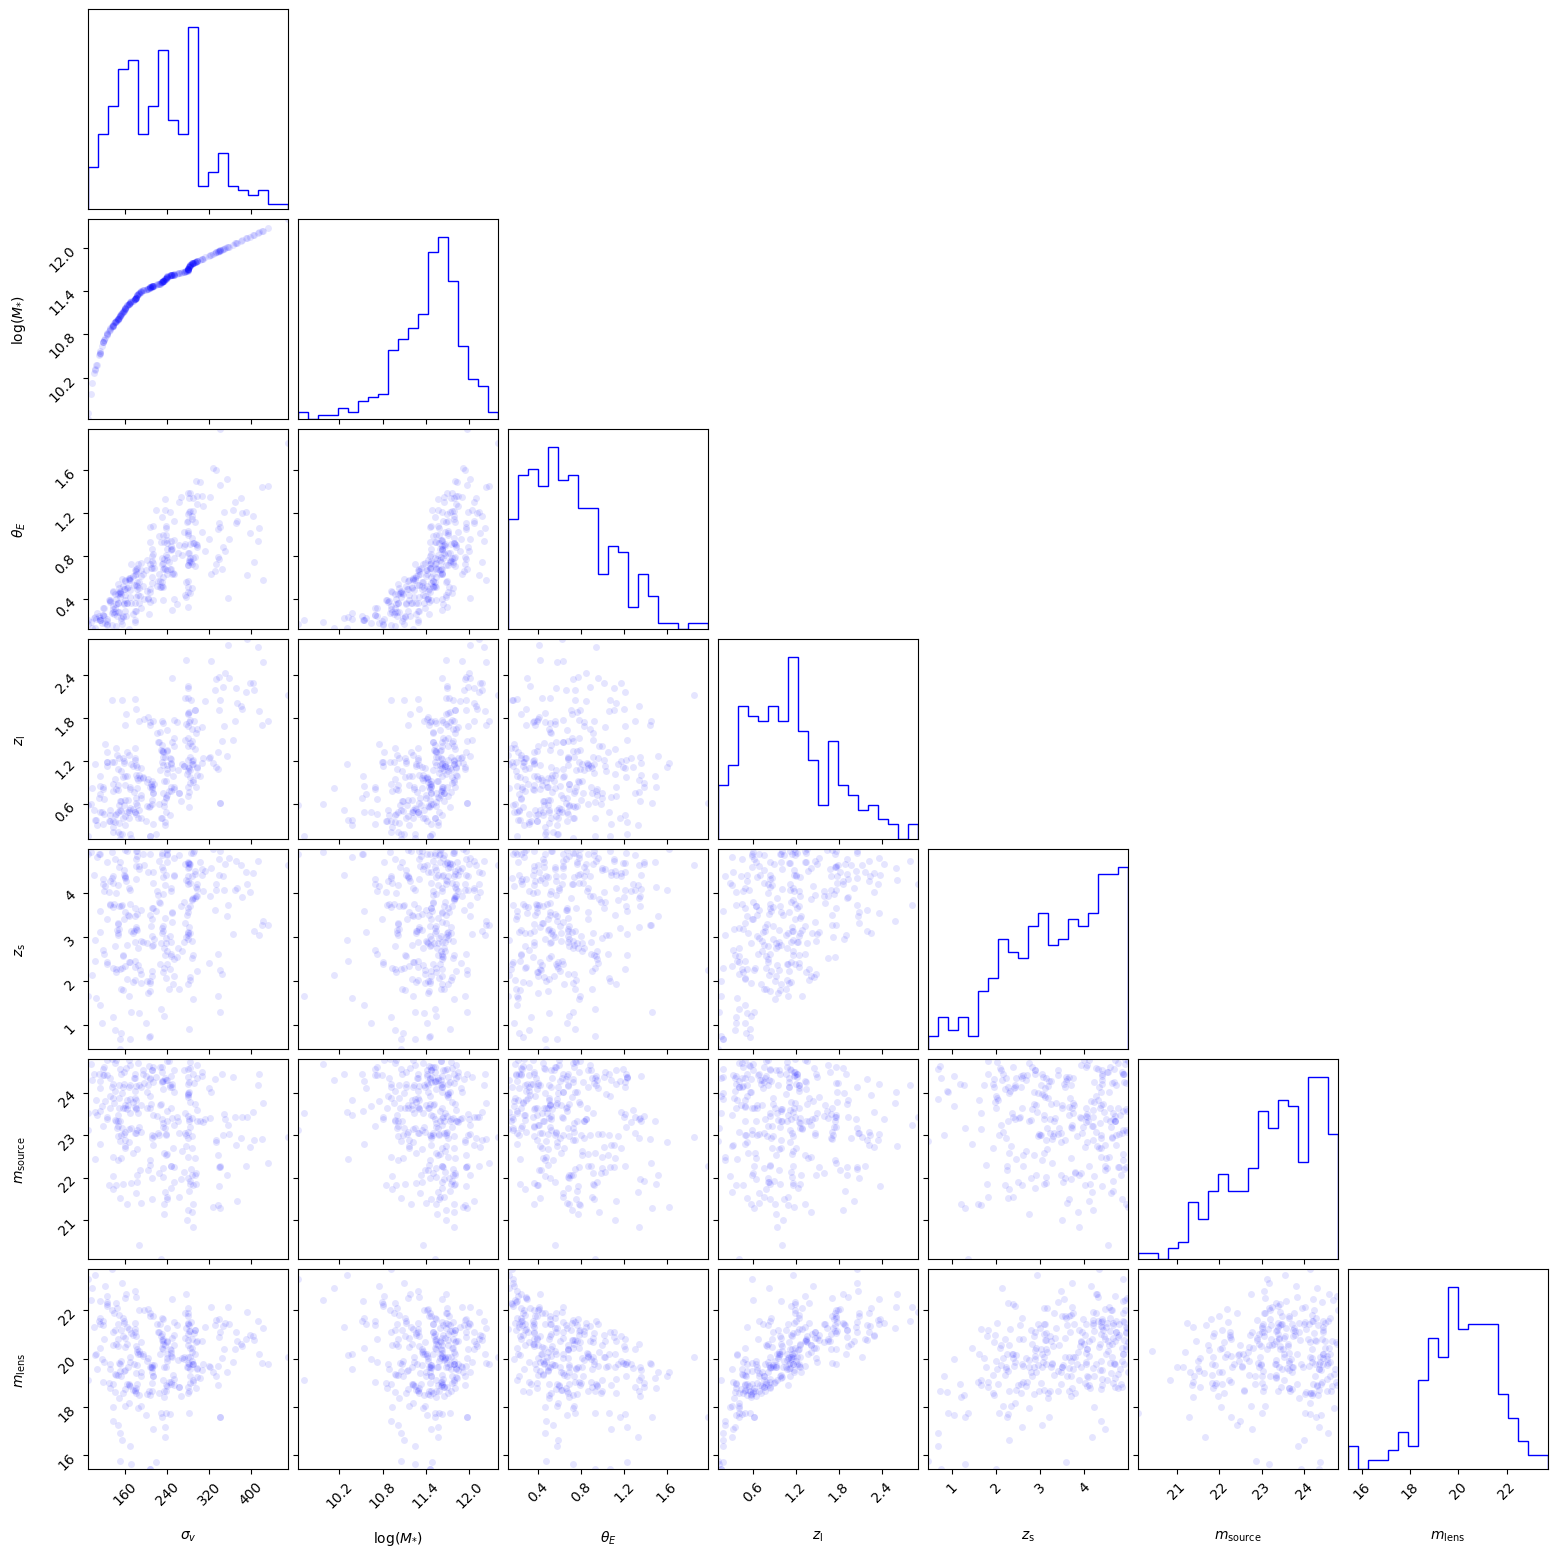

In [51]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()